In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="MSFT"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_aroon = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

In [4]:
# Reference https://www.fmlabs.com/reference/default.htm?url=Aroon.htm

period = 14

# Calculate Periods Since Highest High
df_aroon['periods_since_hh'] = df_aroon['val_high'].rolling(window=period).apply(lambda x: len(x) - 1 - np.argmax(x), raw=True)

# Calculate Periods Since Lowest Low
df_aroon['periods_since_ll'] = df_aroon['val_low'].rolling(window=period).apply(lambda x: len(x) - 1 - np.argmin(x), raw=True)

# Calculate Aroon Up and Aroon Down
df_aroon['aroon_up'] = 100 * (period - df_aroon['periods_since_hh']) / period
df_aroon['aroon_down'] = 100 * (period - df_aroon['periods_since_ll']) / period

# Drop NaN rows (due to rolling windows)
df_aroon.dropna(inplace=True)

In [5]:
df_aroon.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,periods_since_hh,periods_since_ll,aroon_up,aroon_down
date_reference,,,,,,,,,,
2025-10-17,MSFT,513.58,515.48,507.31,509.04,19867765,9.0,3.0,35.714286,78.571429
2025-10-20,MSFT,516.79,518.70,513.43,514.61,14665620,10.0,4.0,28.571429,71.428571
2025-10-21,MSFT,517.66,518.69,513.04,517.50,15586204,11.0,5.0,21.428571,64.285714
2025-10-22,MSFT,520.54,525.23,517.71,521.15,18962694,12.0,6.0,14.285714,57.142857
2025-10-23,MSFT,520.56,523.95,518.61,522.46,14023532,13.0,7.0,7.142857,50.000000


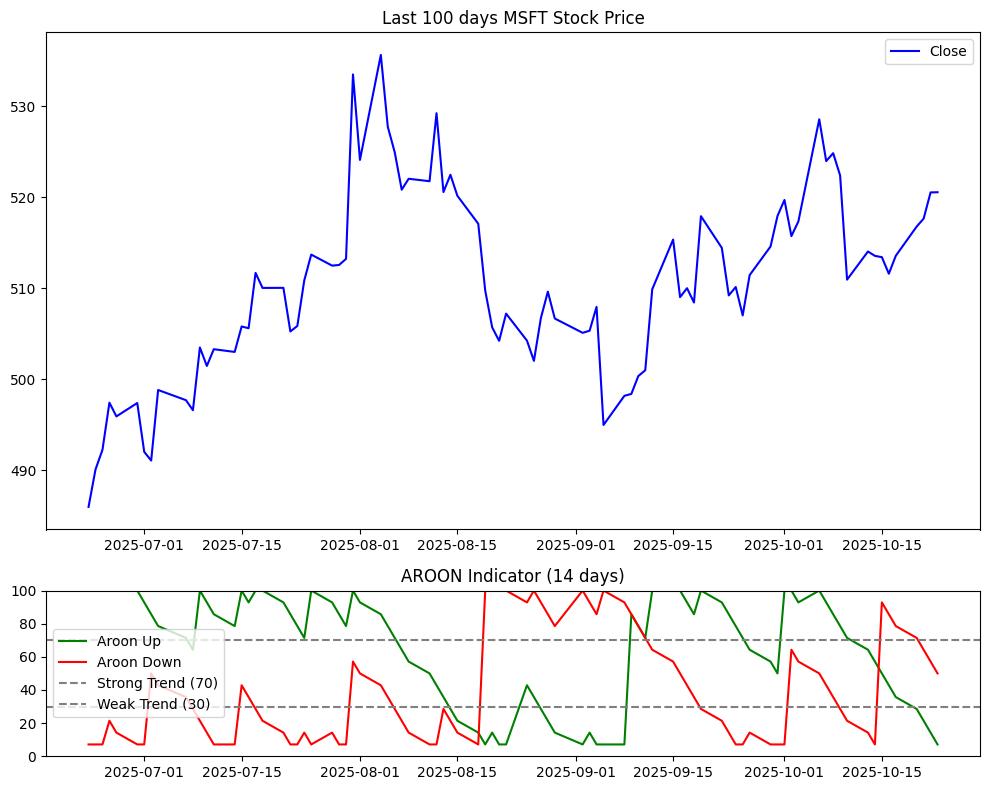

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_aroon.index, df_aroon['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: AROON plot
axs[1].plot(df_aroon.index, df_aroon['aroon_up'], label='Aroon Up', color='green')
axs[1].plot(df_aroon.index, df_aroon['aroon_down'], label='Aroon Down', color='red')
axs[1].axhline(70, color='gray', linestyle='--', label='Strong Trend (70)')
axs[1].axhline(30, color='gray', linestyle='--', label='Weak Trend (30)')
axs[1].set_title(f"AROON Indicator ({period} days)")
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

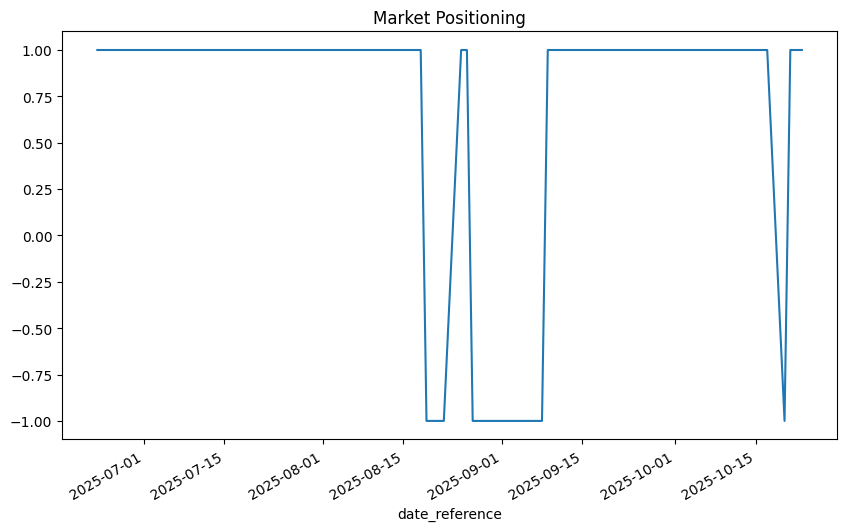

In [7]:
df_aroon['position'] = np.where((df_aroon['aroon_up'] > 70) & (df_aroon['aroon_down'] < 30), 1,                                np.where((df_aroon['aroon_down'] > 70) & (df_aroon['aroon_up'] < 30), -1, 1))
df_aroon['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_aroon['returns'] = np.log(df_aroon['val_close'] / df_aroon['val_close'].shift(1))
df_aroon['strategy'] = df_aroon['position'].shift(1) * df_aroon['returns']
df_aroon[['returns', 'strategy']].sum().apply(np.exp)

returns     1.071111
strategy    1.127742
dtype: float64

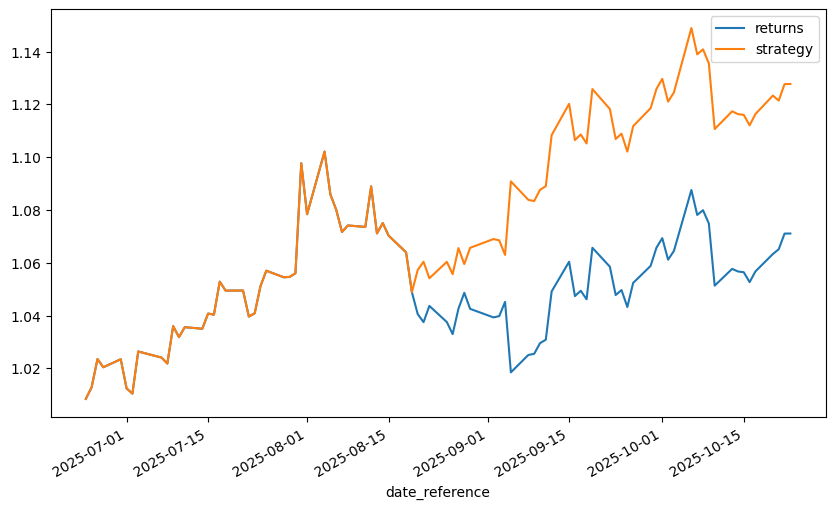

In [9]:
df_aroon[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
df_aroon['aroon_diff'] = df_aroon['aroon_up'] - df_aroon['aroon_down']
df_aroon['prev_aroon_diff'] = df_aroon['aroon_diff'].shift(1)
crossovers = df_aroon[(df_aroon['aroon_diff'] > 0) & (df_aroon['prev_aroon_diff'] <= 0) |  # Up crosses above Down (bullish)
                      (df_aroon['aroon_diff'] < 0) & (df_aroon['prev_aroon_diff'] >= 0)]  # Down crosses above Up (bearish)
print(crossovers[['val_close', 'aroon_up', 'aroon_down', 'position']])

                val_close    aroon_up  aroon_down  position
date_reference                                             
2025-08-19         509.77    7.142857  100.000000        -1
2025-09-12         509.90  100.000000   64.285714         1
2025-10-15         513.43   50.000000   92.857143         1
